In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
m82_sed = pd.read_csv('M82_sed.csv', header=0, names=['wavelength', 'flux_density'])
type1_agn_model = pd.read_csv('type1_agn_model.csv', header=0, names=['wavelength', 'flux_density'])

In [3]:
print("M82 SED Data:")
print(m82_sed.head())
print("\nType 1 AGN Model Data:")
print(type1_agn_model.head())

M82 SED Data:
   wavelength  flux_density
0      1005.0      0.438880
1      1015.0      0.411900
2      1025.0      0.245772
3      1035.0      0.307308
4      1045.0      0.505220

Type 1 AGN Model Data:
   wavelength  flux_density
0      1005.0  1.732890e-07
1      1015.0  1.711364e-07
2      1025.0  1.689838e-07
3      1035.0  1.668312e-07
4      1045.0  1.646786e-07


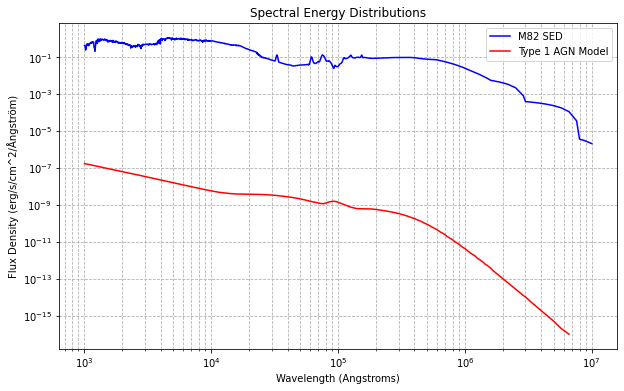

In [4]:
plt.figure(figsize=(10, 6))
m82_sed = m82_sed.replace(0, np.nan).dropna()
type1_agn_model = type1_agn_model.replace(0, np.nan).dropna()

plt.loglog(m82_sed.iloc[:, 0], m82_sed.iloc[:, 1], label='M82 SED', linestyle='-', color='blue')
plt.loglog(type1_agn_model.iloc[:, 0], type1_agn_model.iloc[:, 1], label='Type 1 AGN Model', linestyle='-', color='red')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux Density (erg/s/cm^2/Ångström)')
plt.title('Spectral Energy Distributions')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

Below, I first attempted to normalise each SED to its maximum flux value. This didn't work well, but I left it for you to inspect...

In [5]:
m82_sed['standard_normalized_flux'] = m82_sed['flux_density'] / m82_sed['flux_density'].max()
type1_agn_model['standard_normalized_flux'] = type1_agn_model['flux_density'] / type1_agn_model['flux_density'].max()

In [6]:
alpha_values = np.linspace(0, 1, 5)  # 5 values between 0 and 1. Change to whatever resolution you want here.


hybrid_seds = []

for alpha in alpha_values:
    hybrid_flux = (1 - alpha) * m82_sed['standard_normalized_flux'] + alpha * type1_agn_model['standard_normalized_flux']
    hybrid_seds.append(pd.DataFrame({
        'wavelength': m82_sed['wavelength'],
        'hybrid_flux': hybrid_flux,
        'alpha': alpha
    }))

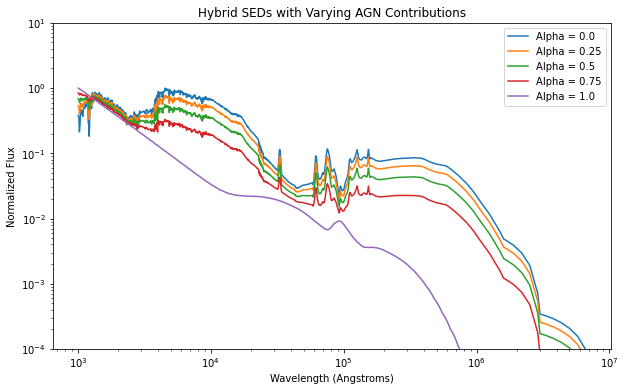

In [7]:
plt.figure(figsize=(10, 6))
for hybrid_sed in hybrid_seds:
    plt.loglog(hybrid_sed['wavelength'], hybrid_sed['hybrid_flux'], label=f'Alpha = {hybrid_sed["alpha"].iloc[0]}')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title('Hybrid SEDs with Varying AGN Contributions')
plt.legend()
plt.ylim(1e-4, 10)
plt.show()


So this turned out pretty bad, and much as expected. This is because the SEDs are not normalised in a way that makes sense for adding or mixing. It's worked at the shorter wavelengths, but almost nothing evident elsewhere. 

Instead, we should normalise the SEDs based on the integral of the flux over the entire wavelength range. This will ensure that the SEDs are normalised based on the total energy output, rather than the maximum flux value. This will give us a more meaningful way to add or mix the SEDs.

In [8]:
# Function to calculate the integral of the flux over a specified wavelength range
def integral_flux(sed):
    return np.trapz(sed['flux_density'], sed['wavelength'])

# Calculate integral flux for each SED
integral_m82 = integral_flux(m82_sed)
integral_agn = integral_flux(type1_agn_model)

# Normalise based on integral flux
m82_sed['integral_normalized_flux'] = m82_sed['flux_density'] / integral_m82
type1_agn_model['integral_normalized_flux'] = type1_agn_model['flux_density'] / integral_agn


In [9]:
alpha_values = np.linspace(0, 1, 5)

hybrid_seds = []

for alpha in alpha_values:
    hybrid_flux = (1 - alpha) * m82_sed['integral_normalized_flux'] + alpha * type1_agn_model['integral_normalized_flux']
    hybrid_seds.append(pd.DataFrame({
        'wavelength': m82_sed['wavelength'], 
        'hybrid_flux': hybrid_flux,
        'alpha': alpha
    }))

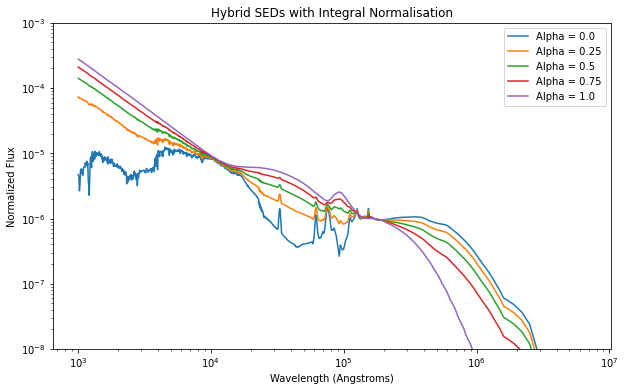

In [10]:
plt.figure(figsize=(10, 6))
for hybrid_sed in hybrid_seds:
    plt.loglog(hybrid_sed['wavelength'], hybrid_sed['hybrid_flux'], label=f'Alpha = {hybrid_sed["alpha"].iloc[0]}')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title('Hybrid SEDs with Integral Normalisation')
plt.legend()
plt.ylim(1e-8, 1e-3)
plt.show()

Looks much better, but now I question the mixing approach. You can see that at longer wavelengths, the AGN contribution does not significantly alter the shape of the SED. This is because the SED of the star-forming galaxy dominates at these wavelengths, and the AGN SED has less emission in this region. This mixing approach works well if we wanted to go from a pure star-forming galaxy to an empirical AGN dominated galaxy. 

If you want to add the two SEDs together, like what you probably want to do here with the pre AGN, you can do so by  adding the flux densities together. We need to adjust the normalisation approach though. Above, the flux densities of both SEDs are being normalised by their respective integrals over the wavelength. This scales the SEDs to their total energy output over the wavelength range, making them directly comparable in terms of their shape and relative energy distribution. However, here we will scale the AGN SED to match the total integrated flux of M82. Or in other words, we're adjusting the entire AGN SED so that its total energy over the wavelength range is the same as M82's before adding. This simulates the effect of "adding" the AGN to M82's SED. There's a bit of a leap here, but I think it is a common approach in the literature.

In [13]:
# Function to calculate the integral of the flux over a specified wavelength range
def integral_flux(sed):
    return np.trapz(sed['flux_density'], sed['wavelength'])

integral_m82 = integral_flux(m82_sed)
integral_agn = integral_flux(type1_agn_model)
scaling_factor = integral_m82 / integral_agn
type1_agn_model['scaled_flux_density'] = type1_agn_model['flux_density'] * scaling_factor
agn_percentages = np.arange(0, 110, 20)  # From 0% to 100%, in steps of 20%. Again, change to whatever.


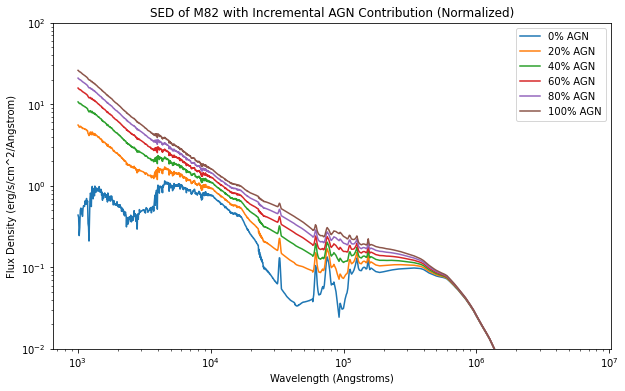

In [14]:
plt.figure(figsize=(10, 6))
for agn_percentage in agn_percentages:
    combined_flux = m82_sed['flux_density'] + (agn_percentage / 100.0) * type1_agn_model['scaled_flux_density']
    plt.loglog(m82_sed['wavelength'], combined_flux, label=f'{agn_percentage}% AGN')

# Add labels and legend
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux Density (erg/s/cm^2/Angstrom)')
plt.title('SED of M82 with Incremental AGN Contribution (Normalized)')
plt.legend()
plt.ylim(1e-2, 100)
plt.show()

Ok, I think this is pretty good. That said, I encourage you to review all the above and decide on an approach that works best for your situation!